In [1]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import seaborn as sns
import time
import gc
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
def reduce_mem(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('{:.2f} Mb, {:.2f} Mb ({:.2f} %)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    gc.collect()
    return df


In [3]:
input_dir = "../data/"
output_dir = "../process_data/"

In [4]:
launch = pd.read_csv(input_dir + "app_launch_logs.csv")
launch.date.min(), launch.date.max()

(100, 222)

In [5]:
# reading test data
test = pd.read_csv(input_dir + "test-a.csv")
test["label"] = -1
test

,user_id,end_date,label
0,10007813,205,-1
1,10052988,210,-1
2,10279068,200,-1
3,10546696,216,-1
4,10406659,183,-1
...,...,...,...
14996,10355586,205,-1
14997,10589773,210,-1
14998,10181954,218,-1
14999,10544736,164,-1


In [6]:
user_list = test['user_id'].unique()
launch = launch.query('user_id in @user_list').reset_index(drop=True)

In [7]:
launch['user_count'] = launch['user_id'].map(launch['user_id'].value_counts())
launch['date_count'] = launch['date'].map(launch['date'].value_counts())

In [8]:
launch.head()

,user_id,launch_type,date,user_count,date_count
0,10106622,0,129,77,2322
1,10319842,0,129,21,2322
2,10383611,0,129,50,2322
3,10305513,0,129,57,2322
4,10563669,0,129,32,2322


In [9]:
launch['launch_type'].value_counts()

0    264948
1      7060
Name: launch_type, dtype: int64

In [10]:
launch_grp = launch.groupby("user_id").agg(
    launch_date=("date", list),
    launch_type=("launch_type", list),
    user_count=("user_count", np.max),
    launch_data_count=("date_count", list)
).reset_index()
launch_grp
del launch
gc.collect()

0

In [11]:
launch_grp['date_len'] = launch_grp.launch_date.apply(lambda x: max(x)-min(x))

C:\Users\wk\Anaconda\envs\torch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='date_len', ylabel='Density'>

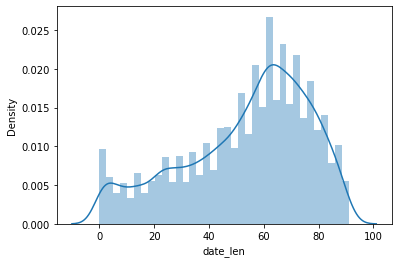

In [12]:
sns.distplot(launch_grp['date_len'])

In [13]:
# generating a sample for each user, a sample should has an anchor date for label
def choose_end_date(launch_date):
    n1, n2 = min(launch_date), max(launch_date)
    if n1 < n2 - 7:
        if n1 < n2-14:
            if np.random.randint(0,10)<5:
                end_date = np.random.randint(n2-14, n2 - 7)
            else:
                end_date = np.random.randint(n1, n2 - 7)
        else:
            end_date = np.random.randint(n1, n2 - 7)
    else:
        end_date = np.random.randint(100, 222 - 7)
    return end_date
launch_grp["end_date"] = launch_grp.launch_date.apply(choose_end_date)
launch_grp

,user_id,launch_date,launch_type,user_count,launch_data_count,date_len,end_date
0,10000176,"[173, 177, 167, 144, 183, 174, 182, 175, 169, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",24,"[3220, 3101, 3529, 3834, 2614, 3207, 2537, 310...",65,136
1,10000263,"[190, 137, 183, 131, 212, 211, 208, 196, 200, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",54,"[2005, 3114, 2614, 3049, 422, 427, 569, 1507, ...",81,202
2,10000355,"[148, 166, 189, 167, 144, 163, 162, 195, 145, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,"[3505, 3413, 2034, 3529, 3834, 3868, 3758, 155...",61,157
3,10000357,"[174, 186, 187, 182, 177, 194, 183, 171, 196, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,"[3207, 2304, 2213, 2537, 3101, 1664, 2614, 342...",31,189
4,10000383,"[134, 176, 156, 181]","[1, 0, 1, 0]",4,"[3283, 3060, 3905, 2594]",47,144
...,...,...,...,...,...,...,...
14996,10599787,"[127, 175, 169, 151]","[0, 0, 0, 0]",4,"[2046, 3108, 3300, 3523]",48,166
14997,10599801,"[135, 105, 103, 111, 142, 152, 143, 127, 124, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",17,"[3517, 1022, 1170, 948, 3675, 3596, 3822, 2046...",53,141
14998,10599950,"[126, 161, 171, 166, 157, 127, 192, 155, 150, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",11,"[2009, 3755, 3429, 3413, 3970, 2046, 1898, 368...",66,134
14999,10599982,"[189, 191, 193, 186, 188, 178, 190, 180, 182, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20,"[2034, 1955, 1715, 2304, 2080, 2993, 2005, 268...",22,181


In [14]:
def get_label(row):
    launch_list = row.launch_date
    end = row.end_date
    label = sum([1 for x in set(launch_list) if end < x < end+8])
    return label
launch_grp["label"] = launch_grp.apply(get_label, axis=1)
launch_grp

,user_id,launch_date,launch_type,user_count,launch_data_count,date_len,end_date,label
0,10000176,"[173, 177, 167, 144, 183, 174, 182, 175, 169, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",24,"[3220, 3101, 3529, 3834, 2614, 3207, 2537, 310...",65,136,0
1,10000263,"[190, 137, 183, 131, 212, 211, 208, 196, 200, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",54,"[2005, 3114, 2614, 3049, 422, 427, 569, 1507, ...",81,202,5
2,10000355,"[148, 166, 189, 167, 144, 163, 162, 195, 145, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,"[3505, 3413, 2034, 3529, 3834, 3868, 3758, 155...",61,157,4
3,10000357,"[174, 186, 187, 182, 177, 194, 183, 171, 196, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,"[3207, 2304, 2213, 2537, 3101, 1664, 2614, 342...",31,189,6
4,10000383,"[134, 176, 156, 181]","[1, 0, 1, 0]",4,"[3283, 3060, 3905, 2594]",47,144,0
...,...,...,...,...,...,...,...,...
14996,10599787,"[127, 175, 169, 151]","[0, 0, 0, 0]",4,"[2046, 3108, 3300, 3523]",48,166,1
14997,10599801,"[135, 105, 103, 111, 142, 152, 143, 127, 124, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",17,"[3517, 1022, 1170, 948, 3675, 3596, 3822, 2046...",53,141,2
14998,10599950,"[126, 161, 171, 166, 157, 127, 192, 155, 150, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",11,"[2009, 3755, 3429, 3413, 3970, 2046, 1898, 368...",66,134,0
14999,10599982,"[189, 191, 193, 186, 188, 178, 190, 180, 182, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20,"[2034, 1955, 1715, 2304, 2080, 2993, 2005, 268...",22,181,7


In [15]:
launch_grp.label.value_counts()

0    5836
1    2826
2    1711
3    1164
7    1005
4     919
5     800
6     740
Name: label, dtype: int64

In [16]:
train = launch_grp[["user_id","end_date","label"]]
train

,user_id,end_date,label
0,10000176,136,0
1,10000263,202,5
2,10000355,157,4
3,10000357,189,6
4,10000383,144,0
...,...,...,...
14996,10599787,166,1
14997,10599801,141,2
14998,10599950,134,0
14999,10599982,181,7


In [17]:
# concat train and test data
data = pd.concat([train, test], ignore_index=True)
data

,user_id,end_date,label
0,10000176,136,0
1,10000263,202,5
2,10000355,157,4
3,10000357,189,6
4,10000383,144,0
...,...,...,...
29997,10355586,205,-1
29998,10589773,210,-1
29999,10181954,218,-1
30000,10544736,164,-1


# launch data process

In [18]:
# append test data to launch_grp
launch_grp = launch_grp.append(
    test.merge(launch_grp[["user_id", "launch_type", "launch_date","user_count","launch_data_count","date_len"]], how="left", on="user_id")
)
launch_grp = reduce_mem(launch_grp)

2.06 Mb, 1.17 Mb (43.06 %)


In [19]:
launch_grp

,user_id,launch_date,launch_type,user_count,launch_data_count,date_len,end_date,label
0,10000176,"[173, 177, 167, 144, 183, 174, 182, 175, 169, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",24,"[3220, 3101, 3529, 3834, 2614, 3207, 2537, 310...",65,136,0
1,10000263,"[190, 137, 183, 131, 212, 211, 208, 196, 200, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",54,"[2005, 3114, 2614, 3049, 422, 427, 569, 1507, ...",81,202,5
2,10000355,"[148, 166, 189, 167, 144, 163, 162, 195, 145, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,"[3505, 3413, 2034, 3529, 3834, 3868, 3758, 155...",61,157,4
3,10000357,"[174, 186, 187, 182, 177, 194, 183, 171, 196, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,"[3207, 2304, 2213, 2537, 3101, 1664, 2614, 342...",31,189,6
4,10000383,"[134, 176, 156, 181]","[1, 0, 1, 0]",4,"[3283, 3060, 3905, 2594]",47,144,0
...,...,...,...,...,...,...,...,...
14996,10355586,"[118, 115, 124]","[0, 1, 0]",3,"[1930, 2239, 2031]",9,205,-1
14997,10589773,"[183, 144, 173, 167, 203, 204, 178, 155, 177, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",76,"[2614, 3834, 3220, 3529, 892, 821, 2993, 3680,...",79,210,-1
14998,10181954,"[152, 155, 153, 144, 150, 143, 158, 151, 154, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[3596, 3680, 3578, 3834, 3890, 3822, 3745, 352...",17,218,-1
14999,10544736,"[138, 117, 105, 148, 113, 116, 115, 158, 154, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[3160, 1994, 1022, 3505, 1021, 1978, 2239, 374...",53,164,-1


In [20]:
# get latest 32 days([end_date-31, end_date]) launch type sequence
# 0 for not launch, 1 for launch_type=0, and 2 for launch_type=1
def gen_launch_seq(row):
    seq_sort = sorted(zip(row.launch_type, row.launch_date), key=lambda x: x[1])
    seq_map = {k: max(g)[0] + 1 for k, g in groupby(seq_sort, lambda x: x[1])}
    end = row.end_date
    seq = [seq_map.get(x, 0) for x in range(end-31, end+1)]
    return seq

#日活用户数量序列
def gen_launch_count_seq(row):
    seq_map = dict(zip(row.launch_date, row.launch_data_count))
    end = row.end_date
    seq = [seq_map.get(x, 0) for x in range(end-31, end+1)]
    return seq
launch_grp["launch_seq"] = launch_grp.apply(gen_launch_seq, axis=1)
launch_grp["launch_count_seq"] = launch_grp.apply(gen_launch_count_seq, axis=1)
launch_grp

,user_id,launch_date,launch_type,user_count,launch_data_count,date_len,end_date,label,launch_seq,launch_count_seq
0,10000176,"[173, 177, 167, 144, 183, 174, 182, 175, 169, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",24,"[3220, 3101, 3529, 3834, 2614, 3207, 2537, 310...",65,136,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,10000263,"[190, 137, 183, 131, 212, 211, 208, 196, 200, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",54,"[2005, 3114, 2614, 3049, 422, 427, 569, 1507, ...",81,202,5,"[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[3429, 3300, 0, 0, 0, 3060, 3101, 2993, 2792, ..."
2,10000355,"[148, 166, 189, 167, 144, 163, 162, 195, 145, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,"[3505, 3413, 2034, 3529, 3834, 3868, 3758, 155...",61,157,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3483, 3114, 0, ..."
3,10000357,"[174, 186, 187, 182, 177, 194, 183, 171, 196, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,"[3207, 2304, 2213, 2537, 3101, 1664, 2614, 342...",31,189,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3300, 3314, ..."
4,10000383,"[134, 176, 156, 181]","[1, 0, 1, 0]",4,"[3283, 3060, 3905, 2594]",47,144,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...
14996,10355586,"[118, 115, 124]","[0, 1, 0]",3,"[1930, 2239, 2031]",9,205,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14997,10589773,"[183, 144, 173, 167, 203, 204, 178, 155, 177, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",76,"[2614, 3834, 3220, 3529, 892, 821, 2993, 3680,...",79,210,-1,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2792, 2685, 2594, 2537, 2614, 2501, 0, 2304, ..."
14998,10181954,"[152, 155, 153, 144, 150, 143, 158, 151, 154, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[3596, 3680, 3578, 3834, 3890, 3822, 3745, 352...",17,218,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14999,10544736,"[138, 117, 105, 148, 113, 116, 115, 158, 154, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[3160, 1994, 1022, 3505, 1021, 1978, 2239, 374...",53,164,-1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 3160, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [21]:
#计算end_date前x天的用户登陆天数
#这里可以构造更多的序列，比如用户每日观看视频时长序列，观看视频完播率序列，每日观看视频个数序列等等序列
#这里可以操作的空间还有很多
x_list = [x*5+1 for x in range(6)]
for x in tqdm(x_list):
    for fea in ['launch_seq','launch_count_seq']:
        launch_grp[f'{x}_before_{fea}_sum'] = launch_grp[fea].apply(lambda seq: np.sum(seq[-x:]))
        launch_grp[f'{x}_before_{fea}_mean'] = launch_grp[fea].apply(lambda seq: np.mean(seq[-x:]))
        launch_grp[f'{x}_before_{fea}_std'] = launch_grp[fea].apply(lambda seq: np.std(seq[-x:]))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.71s/it]


In [22]:
launch_grp

,user_id,launch_date,launch_type,user_count,launch_data_count,date_len,end_date,label,launch_seq,launch_count_seq,...,21_before_launch_seq_std,21_before_launch_count_seq_sum,21_before_launch_count_seq_mean,21_before_launch_count_seq_std,26_before_launch_seq_sum,26_before_launch_seq_mean,26_before_launch_seq_std,26_before_launch_count_seq_sum,26_before_launch_count_seq_mean,26_before_launch_count_seq_std
0,10000176,"[173, 177, 167, 144, 183, 174, 182, 175, 169, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",24,"[3220, 3101, 3529, 3834, 2614, 3207, 2537, 310...",65,136,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0.212959,2058,98.000000,438.269324,1,0.038462,0.192308,2058,79.153846,395.769231
1,10000263,"[190, 137, 183, 131, 212, 211, 208, 196, 200, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",54,"[2005, 3114, 2614, 3049, 422, 427, 569, 1507, ...",81,202,5,"[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[3429, 3300, 0, 0, 0, 3060, 3101, 2993, 2792, ...",...,0.392677,30828,1468.000000,849.045066,21,0.807692,0.394113,42399,1630.730769,977.266933
2,10000355,"[148, 166, 189, 167, 144, 163, 162, 195, 145, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,"[3505, 3413, 2034, 3529, 3834, 3868, 3758, 155...",61,157,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3483, 3114, 0, ...",...,0.485621,46596,2218.857143,1749.119160,14,0.538462,0.498519,50079,1926.115385,1790.047256
3,10000357,"[174, 186, 187, 182, 177, 194, 183, 171, 196, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,"[3207, 2304, 2213, 2537, 3101, 1664, 2614, 342...",31,189,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3300, 3314, ...",...,0.000000,58786,2799.333333,430.770222,21,0.807692,0.394113,58786,2261.000000,1169.208904
4,10000383,"[134, 176, 156, 181]","[1, 0, 1, 0]",4,"[3283, 3060, 3905, 2594]",47,144,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0.425918,3283,156.333333,699.143921,2,0.076923,0.384615,3283,126.269231,631.346154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,10355586,"[118, 115, 124]","[0, 1, 0]",3,"[1930, 2239, 2031]",9,205,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000
14997,10589773,"[183, 144, 173, 167, 203, 204, 178, 155, 177, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",76,"[2614, 3834, 3220, 3529, 892, 821, 2993, 3680,...",79,210,-1,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2792, 2685, 2594, 2537, 2614, 2501, 0, 2304, ...",...,0.293544,21955,1045.476190,582.376872,23,0.884615,0.319486,30586,1176.384615,700.666994
14998,10181954,"[152, 155, 153, 144, 150, 143, 158, 151, 154, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[3596, 3680, 3578, 3834, 3890, 3822, 3745, 352...",17,218,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000
14999,10544736,"[138, 117, 105, 148, 113, 116, 115, 158, 154, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[3160, 1994, 1022, 3505, 1021, 1978, 2239, 374...",53,164,-1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 3160, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0.392677,14836,706.476190,1457.779708,4,0.153846,0.360801,14836,570.615385,1339.391167


In [23]:
x_feature_list = [col for col in launch_grp.columns if 'before' in col]
data = data.merge(
    launch_grp[["user_id", "end_date", "label","user_count"]+x_feature_list],
    on=["user_id", "end_date", "label"],
    how="left"
)
data

,user_id,end_date,label,user_count,1_before_launch_seq_sum,1_before_launch_seq_mean,1_before_launch_seq_std,1_before_launch_count_seq_sum,1_before_launch_count_seq_mean,1_before_launch_count_seq_std,...,21_before_launch_seq_std,21_before_launch_count_seq_sum,21_before_launch_count_seq_mean,21_before_launch_count_seq_std,26_before_launch_seq_sum,26_before_launch_seq_mean,26_before_launch_seq_std,26_before_launch_count_seq_sum,26_before_launch_count_seq_mean,26_before_launch_count_seq_std
0,10000176,136,0,24,0,0.0,0.0,0,0.0,0.0,...,0.212959,2058,98.000000,438.269324,1,0.038462,0.192308,2058,79.153846,395.769231
1,10000263,202,5,54,1,1.0,0.0,985,985.0,0.0,...,0.392677,30828,1468.000000,849.045066,21,0.807692,0.394113,42399,1630.730769,977.266933
2,10000355,157,4,40,0,0.0,0.0,0,0.0,0.0,...,0.485621,46596,2218.857143,1749.119160,14,0.538462,0.498519,50079,1926.115385,1790.047256
3,10000357,189,6,28,1,1.0,0.0,2034,2034.0,0.0,...,0.000000,58786,2799.333333,430.770222,21,0.807692,0.394113,58786,2261.000000,1169.208904
4,10000383,144,0,4,0,0.0,0.0,0,0.0,0.0,...,0.425918,3283,156.333333,699.143921,2,0.076923,0.384615,3283,126.269231,631.346154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29997,10355586,205,-1,3,0,0.0,0.0,0,0.0,0.0,...,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000
29998,10589773,210,-1,76,1,1.0,0.0,493,493.0,0.0,...,0.293544,21955,1045.476190,582.376872,23,0.884615,0.319486,30586,1176.384615,700.666994
29999,10181954,218,-1,13,0,0.0,0.0,0,0.0,0.0,...,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000
30000,10544736,164,-1,13,0,0.0,0.0,0,0.0,0.0,...,0.392677,14836,706.476190,1457.779708,4,0.153846,0.360801,14836,570.615385,1339.391167


# LGB

In [25]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

In [26]:
train_df = data.loc[data.label >= 0].reset_index(drop=True)
test_df = data.loc[data.label < 0].reset_index(drop=True)

In [43]:
drop_feature_list = ['end_date','launch_seq','label','fix_user_count','user_id']#+[x for x in train_df.columns if 'count_' in x]
label = 'label'
feature = [x for x in train_df.columns if x not in drop_feature_list]
print(len(feature),feature)

37 ['user_count', '1_before_launch_seq_sum', '1_before_launch_seq_mean', '1_before_launch_seq_std', '1_before_launch_count_seq_sum', '1_before_launch_count_seq_mean', '1_before_launch_count_seq_std', '6_before_launch_seq_sum', '6_before_launch_seq_mean', '6_before_launch_seq_std', '6_before_launch_count_seq_sum', '6_before_launch_count_seq_mean', '6_before_launch_count_seq_std', '11_before_launch_seq_sum', '11_before_launch_seq_mean', '11_before_launch_seq_std', '11_before_launch_count_seq_sum', '11_before_launch_count_seq_mean', '11_before_launch_count_seq_std', '16_before_launch_seq_sum', '16_before_launch_seq_mean', '16_before_launch_seq_std', '16_before_launch_count_seq_sum', '16_before_launch_count_seq_mean', '16_before_launch_count_seq_std', '21_before_launch_seq_sum', '21_before_launch_seq_mean', '21_before_launch_seq_std', '21_before_launch_count_seq_sum', '21_before_launch_count_seq_mean', '21_before_launch_count_seq_std', '26_before_launch_seq_sum', '26_before_launch_seq_mean

In [44]:
#lgb
def lgb_custom_metric(y_true,y_pre):
    y_pre = y_pre.get_label()
    score = 100*(1-np.mean((np.abs(y_pre.reshape(-1) - y_true.reshape(-1))/7)))
    return 'self-metric', score, True
#自己用的
def custom_metric(y_true,y_pre):
    score = 100*(1-np.mean((np.abs(y_pre.reshape(-1) - y_true.reshape(-1))/7)))
    return score

In [45]:
n_fold = 5
#lgb参数
lgb_params = {
    "boosting_type": "gbdt",
    "objective": "mae",
    "learning_rate": 0.01,
    "max_depth": -1,
    "num_leaves": 15,
    "nthread":-1
    
}
y_val = np.zeros((train_df.shape[0]))
y_test = np.zeros((test_df.shape[0]))
score_list = []
skf = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=42)
#StratifiedKFold，KFold有什么区别？
for train_index,valid_index in skf.split(train_df[feature],train_df[label]):
    x_train,x_valid,y_train,y_valid = train_df[feature].iloc[train_index],train_df[feature].iloc[valid_index],train_df[label].iloc[train_index],train_df[label].iloc[valid_index]

    train_data = lgb.Dataset(x_train,label=y_train)
    valid_data = lgb.Dataset(x_valid,label=y_valid)
    
    model = lgb.train(lgb_params,train_data,valid_sets=[valid_data],num_boost_round=1000,verbose_eval=50, early_stopping_rounds = 50,feval=lgb_custom_metric)
    
    y_val[valid_index] = model.predict(x_valid)
    y_test += np.array(model.predict(test_df[feature])/n_fold)

cv_score = custom_metric(y_val,train_df[label].values)
print(f'local cv: {cv_score}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4403
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 35
[LightGBM] [Info] Start training from score 1.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l1: 1.3302	valid_0's self-metric: 80.9972
[100]	valid_0's l1: 1.14235	valid_0's self-metric: 83.6806
[150]	valid_0's l1: 1.04455	valid_0's self-metric: 85.0779
[200]	valid_0's l1: 0.996656	valid_0's self-metric: 85.7621
[250]	valid_0's l1: 0.971264	valid_0's self-metric: 86.1248
[300]	valid_0's l1: 0.958247	valid_0's self-metric: 86.3108
[350]	valid_0's l1: 0.951778	valid_0's self-metric: 86.4032
[400]	valid_0's l1: 0.948263	valid_0's self-metric: 86.4534
[450]	valid_0's l1: 0.946211	valid_0's self-metric: 86.4827
[500]	valid_0's l1: 0.944821	valid_0's self-metric: 86.5026

In [46]:
#特征重要性
feature_imp_df = pd.DataFrame()
feature_imp_df['fea_name'] = model.feature_name()
feature_imp_df['fea_imp'] = model.feature_importance()
feature_imp_df = feature_imp_df.sort_values('fea_imp',ascending=False)
feature_imp_df

,fea_name,fea_imp
0,user_count,5008
34,26_before_launch_count_seq_sum,1822
31,26_before_launch_seq_sum,1370
12,6_before_launch_count_seq_std,836
10,6_before_launch_count_seq_sum,794
19,16_before_launch_seq_sum,712
4,1_before_launch_count_seq_sum,692
28,21_before_launch_count_seq_sum,641
16,11_before_launch_count_seq_sum,353
25,21_before_launch_seq_sum,247


In [48]:
def handle_result(x):
    if x<=0:
        return 0
    elif x>=7:
        return 7
    else:
        return x

In [47]:
res = pd.DataFrame()
res['user_id'] = test_df['user_id']
res['pre'] = y_test
res['pre'] = res['pre'].apply(handle_result)
res.to_csv(f"lgb_base_{cv_score}.csv", index=False, header=False, float_format="%.2f")